## CAPM Regression of Returns to Find Alpha & Beta ##
 **The Capital Asset Pricing Model (CAPM):**
 
 $$
 \mathbb{E}[R_i] = r_f + \beta_i \big(\mathbb{E}[R_m] - r_f\big)
 $$
 
 - $\mathbb{E}[R_i]$ : Expected return of asset $i$
 - $r_f$ : Risk-free rate   
 - $\beta_i$ : Sensitivity (“beta”) of $i$ to market returns
 - $\mathbb{E}[R_m]$ : Expected market return
 - $\big(\mathbb{E}[R_m] - r_f\big)$ : Market risk premium
 
Reference: Sharpe, W.F. (1964). "Capital Asset Prices: A Theory of Market Equilibrium under Conditions of Risk." Journal of Finance.

 
 The standard CAPM model (above) has no "alpha" term—CAPM assumes the market is efficient, so on average, all assets plot exactly on the line: 
 
 $$\mathbb{E}[R_i] = r_f + \beta_i (\mathbb{E}[R_m] - r_f)$$
 
 In real data, we often observe persistent deviations from this line. 
 
 We capture these deviations with an **"alpha"** term by amending the regression equation:
 
 $$
 R_i = \alpha_i + r_f + \beta_i (R_m - r_f) + \varepsilon
 $$
 
 Here, $\alpha_i$ (alpha) measures the excess return of asset $i$ beyond what is predicted by beta and the market, after adjusting for risk-free rate. If $\alpha>0$, the asset or portfolio is "beating CAPM"; if $\alpha<0$, it's underperforming.



In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [67]:
# Pull historical data from yfinance starting from the year 2000
ticker = "^RUT"
market_data = yf.download(ticker, start="2000-01-01", multi_level_index=False) 
market_data['market_rets'] = market_data['Close'].pct_change()
market_data = market_data.dropna()
display(market_data.head())
display(market_data.tail())

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume,market_rets
Date,,,,,,
2000-01-04,478.380005,497.049988,478.200012,497.049988,1009000000,-0.036340
2000-01-05,478.829987,479.480011,467.559998,478.380005,1085500000,0.000941
2000-01-06,475.339996,480.190002,474.399994,478.829987,1092300000,-0.007289
2000-01-07,488.309998,488.309998,475.339996,475.339996,1225200000,0.027286
2000-01-10,501.890015,505.959991,488.309998,488.309998,1064800000,0.027810


,Close,High,Low,Open,Volume,market_rets
Date,,,,,,
2026-02-17,2646.590088,2659.459961,2611.340088,2644.199951,5418480000,-0.000042
2026-02-18,2658.610107,2686.760010,2644.479980,2646.929932,5098160000,0.004542
2026-02-19,2665.090088,2665.219971,2637.580078,2648.100098,5151690000,0.002437
2026-02-20,2663.780029,2682.419922,2642.070068,2660.290039,5432480000,-0.000492
2026-02-23,2620.989990,2659.300049,2600.989990,2654.830078,5638350000,-0.016064


In [68]:
#Get returns data (depends on fund)
fund_data = pd.read_csv("M:/_Intern Folder/Matthew/Parkman Data Analysis Project/Fund_Returns.csv")  
fund_data = fund_data[['Date', 'Return']].dropna() # Must have only 2 columns called Date and Return

# Prepare fund returns
fund_data['Date'] = pd.to_datetime(fund_data['Date'])
fund_data = fund_data.set_index('Date').sort_index()
# Returns must be in decimals (no percentages)

display(fund_data.head())
display(fund_data.tail())

C:\Users\admin\AppData\Local\Temp\ipykernel_21304\1516688334.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  fund_data['Date'] = pd.to_datetime(fund_data['Date'])


,Return
Date,
2019-06-30,0.0085
2019-07-31,-0.0154
2019-08-31,-0.0289
2019-09-30,-0.0367
2019-10-31,0.0280


,Return
Date,
2025-09-30,0.0246
2025-10-31,0.0187
2025-11-30,0.0344
2025-12-31,-0.0088
2026-01-31,-0.0120


In [69]:
#Get 10-year treasury bill data for each month
rf = pd.read_csv("C:/Users/admin/Desktop/Python Projects/10_yr_treasury_monthly.csv") #columns are "Date" and "Yield"
rf['Date'] = pd.to_datetime(rf['Date'])
rf = rf.set_index('Date')

#De-annualize it to monthly rate, change to decimal
rf['Yield'] = rf['Yield'] / 12 / 100
rf

,Yield
Date,
2026-01-30,0.003531
2025-12-31,0.003474
2025-11-28,0.003346
2025-10-31,0.003398
2025-09-30,0.003459
...,...
2000-05-31,0.005227
2000-04-28,0.005177
2000-03-31,0.005003


In [70]:
#get fund returns and market returns
fund_rets = fund_data['Return']

#Change this depending on the hedge fund returns data frequency
market_rets = market_data['market_rets'].resample('M').apply(lambda x: (1 + x).prod() - 1) #monthly
# market_rets = df['market_rets'].resample('D') #daily

# force all dates to the calendar month end
fund_rets.index = fund_rets.index.to_period('M').to_timestamp('M')
market_rets.index = market_rets.index.to_period('M').to_timestamp('M')
rf.index = rf.index.to_period('M').to_timestamp('M')

#SANITY CHECKS
market_rets.to_csv('market_returns.csv')
rf.to_csv('monthly_yield.csv')
fund_rets.to_csv('fund_returns.csv')

# Align series on common dates
df = pd.concat([fund_rets, market_rets, rf], axis = 1, join='inner')
df.columns = ['Return', 'Market Return', 'Risk Free']
df

C:\Users\admin\AppData\Local\Temp\ipykernel_21304\1459807395.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  market_rets = market_data['market_rets'].resample('M').apply(lambda x: (1 + x).prod() - 1) #monthly


,Return,Market Return,Risk Free
Date,,,
2019-06-30,0.0085,0.068973,0.001672
2019-07-31,-0.0154,0.005132,0.001679
2019-08-31,-0.0289,-0.050660,0.001248
2019-09-30,-0.0367,0.019086,0.001388
2019-10-31,0.0280,0.025654,0.001410
...,...,...,...
2025-09-30,0.0246,0.029606,0.003459
2025-10-31,0.0187,0.017607,0.003398
2025-11-30,0.0344,0.008490,0.003346


### Returns with risk-free rate ###

beta = 0.1441, alpha = 0.005429
mean alpha component = 0.005429
mean beta component  = 0.001003
R^2 = 0.176218


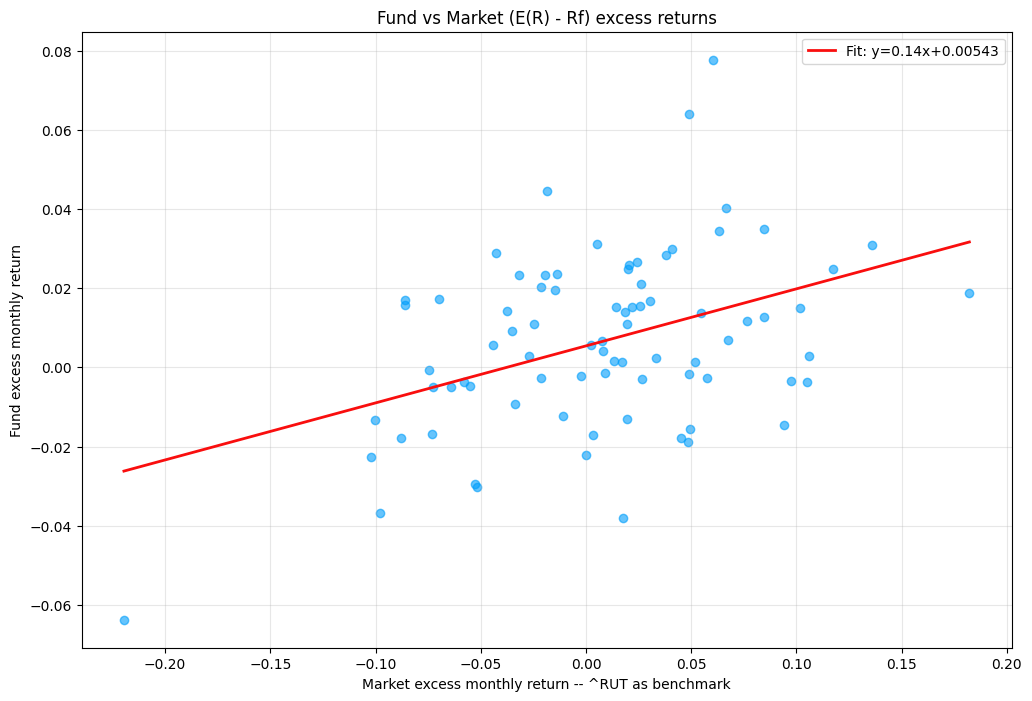

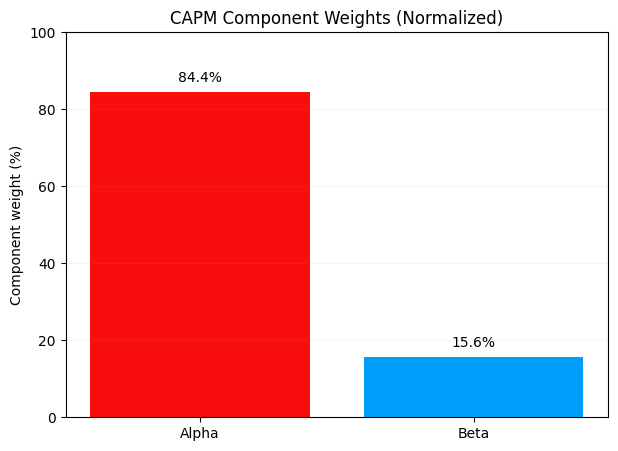

In [71]:
alpha_color = "#f90e0eff"
beta_color = '#009efb'

market_excess = df['Market Return'] - df['Risk Free']

fund_excess = df['Return'] - df['Risk Free']

# CAPM regression on excess returns: fund_excess = alpha + beta * market_excess
beta, alpha = np.polyfit(market_excess, fund_excess, 1)

# Mean components (no residual/noise term)
alpha_component = float(alpha)
beta_component = float(beta) * float(market_excess.mean())

print(f'beta = {beta:.4f}, alpha = {alpha:.6f}')
print(f'mean alpha component = {alpha_component:.6f}')
print(f'mean beta component  = {beta_component:.6f}')

# Normalize components (0-100%)
components = [alpha_component, beta_component]
components_sum = float(sum(components))
components_pct = [x / components_sum * 100.0 for x in components]

# Scatter plot to display the fund's return corelation with market
x = market_excess.dropna() # x is a series
y = fund_excess.reindex(x.index).dropna()
x = x.reindex(y.index)

#find r squared for style points
y_hat = alpha + beta * x  
ss_res = ((y - y_hat) ** 2).sum()
ss_tot = ((y - y.mean()) ** 2).sum()
r2 = 1 - ss_res / ss_tot
print(f"R^2 = {r2:.6f}")

# Fitted line: y = alpha + beta * x
x_sorted = x.sort_values()
y_fit = alpha + beta * x_sorted
plt.figure(figsize=(12, 8))
plt.scatter(x, y, alpha=0.6, color=beta_color)
plt.plot(
    x_sorted,
    y_fit,
    color=alpha_color,
    linewidth=2,
    label=f"Fit: y={beta:.2f}x+{alpha:.5f}",
)
plt.xlabel(f"Market excess monthly return -- {ticker} as benchmark")
plt.ylabel("Fund excess monthly return")
plt.title("Fund vs Market (E(R) - Rf) excess returns")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Plot normalized alpha and beta (0-100%)

labels = ['Alpha', 'Beta']
colors = [alpha_color, beta_color]

plt.figure(figsize=(7, 5))
bars = plt.bar(labels, components_pct, color=colors)
plt.ylabel("Component weight (%)")
plt.title("CAPM Component Weights (Normalized)")
plt.ylim(0, 100)
plt.grid(axis="y", alpha=0.1)
for b in bars:
    h = b.get_height()
    plt.text(
        b.get_x() + b.get_width() / 2,
        h + 2,
        f"{h:.1f}%",
        ha="center",
        va="bottom",
    )
plt.show()

